### Loved Brands Bootstrap Analysis for 4 vendor elasticity groups

In [14]:
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
pd.set_option("display.max_columns", 100)

In [19]:

# Declare some global inputs
test_names = ["PE_20230410_R_B0_O_LovedBrands_AQPv2","TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave","TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave","CR_20230519_R_B0_R_LovedBrandsSanJose_v2"]
#lb_pipeline_run_date = "2023-07-06"
asa_ids = ["4","2028","2034","15"]
#entity_id = ["PY_PE","FP_TH","PY_CR"]
#b_designated_tg = "Target Group 1" # Depending on whether or not there are conditions in the test, the Loved Brands can be in other target groups different from TG1
#nlb_designated_tg = "Target Group 2" # Depending on whether or not there are conditions in the test, the non-Loved Brands can be in other target groups different from TG2
#ela_var = "Variation1" # Elasticity variant in the test
num_bootstrap_samples = 1000 # Number of data points to have on the histogram
cl = 0.95
left_threshold = round((1 - cl) / 2, 4)
right_threshold = round((1 - (1 - cl) / 2), 4)

# Create a data frame combining the test name with the targeted ASA
df_test_asa = pd.DataFrame({"test_name": test_names, "asa_id_of_test": asa_ids})

In [4]:
# Instantiate the BQ client
client = bigquery.Client(project="logistics-customer-staging")
bqstorage_client = bigquery_storage.BigQueryReadClient()

c:\Users\s.bhattacharya.3\Documents\Codebase\elasticity_test_analysis\bq_venv\Lib\site-packages\google\auth\_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [89]:
#Query the test data and join the resulting data frame with df_test_asa
df_test_data = client.query(
    query=f"""
        SELECT * FROM `logistics-data-storage-staging.long_term_pricing.ab_test_individual_orders_cleaned_lb_rollout_tests`
        WHERE test_name IN ('{"', '".join(test_names)}') AND created_date_utc >= DATE("2023-01-01")
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

df_test_data = pd.merge(left=df_test_data, right=df_test_asa, how="left", on="test_name")

c:\Users\s.bhattacharya.3\Documents\Codebase\elasticity_test_analysis\bq_venv\Lib\site-packages\google\cloud\bigquery\table.py:2151: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


### BootStrap Function, common functions and variable definitions

In [56]:
### bootstrap function 
def bootstrap_sampling(test_name,full_lbs,non_lbs_all,non_lbs_only,non_analyzed, df_test_data,vendor_labels, num_bootstrap_samples,ela_var):
    sim_results = []
    sim_counter = 1
    for j in vendor_labels: 
        if j == "full_lbs": 
            df_sub_test = df_test_data[df_test_data["vendor_id"].isin(full_lbs["vendor_code"])]
        elif j == "non_lbs_all":
            df_sub_test = df_test_data[df_test_data["vendor_id"].isin(non_lbs_all["vendor_code"])]
        elif j == "non_lbs_only":
            df_sub_test = df_test_data[df_test_data["vendor_id"].isin(non_lbs_only["vendor_code"])]
        else: 
            df_sub_test = df_test_data[df_test_data["vendor_id"].isin(non_analyzed["vendor_code"])]

        for k in range(1, num_bootstrap_samples+1): 
            print(f"Iteration {sim_counter}. Sampling with the following parameters --> test_name: {test_name}, vendor_group_label: {j}, sample_num: {k}")

            df_ctl_sample = df_sub_test[df_sub_test["variant"] == "Control"].sample(frac=1, replace=True)
            df_var_sample = df_sub_test[df_sub_test["variant"] == ela_var].sample(frac=1, replace=True)

            num_orders_ctl = df_ctl_sample["platform_order_code"].nunique()
            num_orders_var = df_var_sample["platform_order_code"].nunique()

            avg_df_ctl = df_ctl_sample["delivery_fee_local"].sum() / num_orders_ctl
            avg_df_var = df_var_sample["delivery_fee_local"].sum() / num_orders_var

            pct_diff_orders = float((num_orders_var - num_orders_ctl) / num_orders_ctl)
            pct_diff_avg_df = float((avg_df_var - avg_df_ctl) / avg_df_ctl)

            elasticity = pct_diff_orders / pct_diff_avg_df

            output_dict = {
                "test_name": test_name,
                "vendor_group_label": j,
                "sample_num": k,
                "elasticity": elasticity,
                "pct_diff_orders": pct_diff_orders,
                "pct_diff_avg_df": pct_diff_avg_df,
            }

            sim_results.append(output_dict)
            sim_counter += 1

    return sim_results

In [57]:
# Calculate the mean elasticity of LBs, non-LBs, and simple LBs per test
def percentile_left(x):
    return x.quantile(left_threshold)

def percentile_right(x):
    return x.quantile(right_threshold)

In [63]:
# Create three data frames for simple LBs, full LBs and non-LBs
common_cols = [
    "region",
    "entity_id",
    "country_code",
    "asa_id",
    "master_asa_id",
    "asa_name",
    "asa_common_name",
    "vendor_code",
    "vertical_type",
    "vendor_rank_lm",
    "is_lb_lm",
]

In [64]:
def create_vendor_groups(df_test_data,common_cols):
    full_lbs = df_test_data[df_test_data["is_lb_lm"] == "Y"][common_cols].reset_index()
    non_analyzed = df_test_data[df_test_data["vendor_rank_lm"] == "Bottom 75%"][common_cols].reset_index()
    non_lbs_all = df_test_data[df_test_data["is_lb_lm"] == "N"][common_cols].reset_index()
    non_lbs_only = df_test_data[(df_test_data["is_lb_lm"]=="N") & (df_test_data["vendor_rank_lm"]=="Top 25%")][common_cols].reset_index()
    return full_lbs, non_analyzed,non_lbs_all, non_lbs_only

In [60]:
def display_vendor_count(full_lbs, non_analyzed, non_lbs_all,non_lbs_only): 
    print("The number of Loved Brands per ASA...")
    display(full_lbs.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

    print("\nThe number of non-analyzed vendors per ASA...")
    display(non_analyzed.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

    print("\nThe number of non-Loved Brands per ASA including vendors in the Bottom 75%...")
    display(non_lbs_all.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

    print("\nThe number of non-Loved Brands per ASA excluding vendors in the Bottom 75%...")
    display(non_lbs_only.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

##### Aggregation Functions

In [74]:
list_of_agg_functions = ["mean", percentile_left, percentile_right]
agg_func_selection = {"elasticity": list_of_agg_functions, "pct_diff_orders": list_of_agg_functions, "pct_diff_avg_df": list_of_agg_functions}

In [75]:
def aggregation_function(df_results): 
    df_stats = df_results.groupby(["test_name", "vendor_group_label"])[["elasticity", "pct_diff_orders", "pct_diff_avg_df"]].agg(agg_func_selection).reset_index()
    return df_stats

### PE_20230410_R_B0_O_LovedBrands_AQPv2

Peru Test with Variation 1 and Variation 2 as elasticity variants

In [91]:
test_pe = 'PE_20230410_R_B0_O_LovedBrands_AQPv2'
pipeline_run = '2023-05-05' #Pipeline Run Date
entity_id = 'PY_PE'
asa_id = "4"

In [92]:
# Query the Loved Brands based on the last pipeline run
df_lb_pipeline_pe = client.query(
    query=f"""
        SELECT * FROM `logistics-data-storage-staging.long_term_pricing.final_vendor_list_all_data_loved_brands_scaled_code`
        WHERE TRUE
            AND DATE(update_timestamp) = DATE("{pipeline_run}")
            AND asa_id = {asa_id}
            AND entity_id ='{entity_id}'
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

c:\Users\s.bhattacharya.3\Documents\Codebase\elasticity_test_analysis\bq_venv\Lib\site-packages\google\cloud\bigquery\table.py:2151: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [71]:
full_lbs_pe,non_analyzed_pe, non_lbs_all_pe,non_lbs_only_pe = create_vendor_groups(df_lb_pipeline_pe,common_cols)

In [73]:
display_vendor_count(full_lbs_pe,non_analyzed_pe,non_lbs_all_pe,non_lbs_only_pe)

The number of Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,PY_PE,4,Y,63



The number of non-analyzed vendors per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,PY_PE,4,N,625



The number of non-Loved Brands per ASA including vendors in the Bottom 75%...


,entity_id,asa_id,is_lb_lm,vendor_code
0,PY_PE,4,N,673



The number of non-Loved Brands per ASA excluding vendors in the Bottom 75%...


,entity_id,asa_id,is_lb_lm,vendor_code
0,PY_PE,4,N,48


##### Consider Variation 1 as elasticity variant

In [45]:
pe_results = bootstrap_sampling(
    test_name=test_pe,
    full_lbs=full_lbs_pe,
    non_lbs_all=non_lbs_all_pe,
    non_lbs_only=non_lbs_only_pe,
    non_analyzed=non_analyzed_pe,
    df_test_data = df_test_data[df_test_data["test_name"]==test_pe],
    vendor_labels=["full_lbs","non_lbs_only","non_lbs_all","non_analyzed"],
    num_bootstrap_samples=num_bootstrap_samples,
    ela_var="Variation1"
)

df_pe_results = pd.DataFrame(pe_results)

Iteration 1. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 1
Iteration 2. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 2
Iteration 3. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 3
Iteration 4. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 4
Iteration 5. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 5
Iteration 6. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 6
Iteration 7. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, v

In [76]:
df_pe_stats = aggregation_function(df_pe_results)
df_pe_stats

test_name vendor_group_label elasticity  \
                                                                 mean   
0  PE_20230410_R_B0_O_LovedBrands_AQPv2           full_lbs   0.196114   
1  PE_20230410_R_B0_O_LovedBrands_AQPv2       non_analyzed  -0.411574   
2  PE_20230410_R_B0_O_LovedBrands_AQPv2        non_lbs_all  -0.386013   
3  PE_20230410_R_B0_O_LovedBrands_AQPv2       non_lbs_only  -0.365663   

                                   pct_diff_orders                  \
  percentile_left percentile_right            mean percentile_left   
0       -0.076434         0.622070        0.013160       -0.007571   
1       -0.547516        -0.225714       -0.036246       -0.058472   
2       -0.472320        -0.278982       -0.037545       -0.052517   
3       -0.471851        -0.225928       -0.039052       -0.059052   

                   pct_diff_avg_df                                   
  percentile_right            mean percentile_left percentile_right  
0         0.033632        0.077440        0.053584         0.102733  
1        -0.013979        0.086130        0.057577         0.113896  
2        -0.023476        0.096461        0.077710         0.116532  
3        -0.018597        0.105367        0.079855         0.131431

##### Consider Variant 2 as elasticity variant 
Variation 2 had a Avg.TT Fee change of -10%

In [77]:
pe_results_2 = bootstrap_sampling(
    test_name=test_pe,
    full_lbs=full_lbs_pe,
    non_lbs_all=non_lbs_all_pe,
    non_lbs_only=non_lbs_only_pe,
    non_analyzed=non_analyzed_pe,
    df_test_data = df_test_data[df_test_data["test_name"]==test_pe],
    vendor_labels=["full_lbs","non_lbs_only","non_lbs_all","non_analyzed"],
    num_bootstrap_samples=num_bootstrap_samples,
    ela_var="Variation2"
)

df_pe_results_2 = pd.DataFrame(pe_results_2)

Iteration 1. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 1
Iteration 2. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 2
Iteration 3. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 3
Iteration 4. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 4
Iteration 5. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 5
Iteration 6. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, vendor_group_label: full_lbs, sample_num: 6
Iteration 7. Sampling with the following parameters --> test_name: PE_20230410_R_B0_O_LovedBrands_AQPv2, v

### TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave and TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave

TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave - V4 is the elasticity variant with an Avg. TT Fee increase of 12%.


In [112]:
test_th_1 = 'TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave'
test_th_2 = 'TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave'
pipeline_run_th = '2023-07-06' #Pipeline Run Date
entity_id_th = 'FP_TH'
asa_id_th_1 = "2028"
asa_id_th_2 = "2034"

In [99]:
# Query the Loved Brands based on the last pipeline run
df_lb_pipeline_th = client.query(
    query=f"""
        SELECT * FROM `logistics-data-storage-staging.long_term_pricing.final_vendor_list_all_data_loved_brands_scaled_code`
        WHERE TRUE
            AND DATE(update_timestamp) = DATE("{pipeline_run_th}")
            AND asa_id = {asa_id_th_1}
            AND entity_id ='{entity_id_th}'
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

c:\Users\s.bhattacharya.3\Documents\Codebase\elasticity_test_analysis\bq_venv\Lib\site-packages\google\cloud\bigquery\table.py:2151: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [100]:
full_lbs_th_1,non_analyzed_th_1, non_lbs_all_th_1,non_lbs_only_th_1 = create_vendor_groups(df_lb_pipeline_th,common_cols)

In [101]:
display_vendor_count(full_lbs_th_1,non_analyzed_th_1, non_lbs_all_th_1,non_lbs_only_th_1)

The number of Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_TH,2028,Y,70



The number of non-analyzed vendors per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_TH,2028,N,1064



The number of non-Loved Brands per ASA including vendors in the Bottom 75%...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_TH,2028,N,1173



The number of non-Loved Brands per ASA excluding vendors in the Bottom 75%...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_TH,2028,N,109


In [102]:
th_results_1 = bootstrap_sampling(
    test_name=test_th_1,
    full_lbs=full_lbs_th_1,
    non_lbs_all=non_lbs_all_th_1,
    non_lbs_only=non_lbs_only_th_1,
    non_analyzed=non_analyzed_th_1,
    df_test_data = df_test_data[df_test_data["test_name"]==test_th_1],
    vendor_labels=["full_lbs","non_lbs_only","non_lbs_all","non_analyzed"],
    num_bootstrap_samples=num_bootstrap_samples,
    ela_var="Variation4"
)

df_th_results_1 = pd.DataFrame(th_results_1)

Iteration 1. Sampling with the following parameters --> test_name: TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave, vendor_group_label: full_lbs, sample_num: 1
Iteration 2. Sampling with the following parameters --> test_name: TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave, vendor_group_label: full_lbs, sample_num: 2
Iteration 3. Sampling with the following parameters --> test_name: TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave, vendor_group_label: full_lbs, sample_num: 3
Iteration 4. Sampling with the following parameters --> test_name: TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave, vendor_group_label: full_lbs, sample_num: 4
Iteration 5. Sampling with the following parameters --> test_name: TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave, vendor_group_label: full_lbs, sample_num: 5
Iteration 6. Sampling with the following parameters --> test_name: TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave, vendor_group_label: full_lbs, sample_num: 6
Iteration 7. Sampling with the following param

In [131]:
min_elas = -1.0
max_elas = 1.0
df_th_1_filtered = df_th_results_1[(df_th_results_1['elasticity'] >= min_elas) & (df_th_results_1['elasticity'] <= max_elas)]

TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave - V4 is the elasticity variant with an Avg. TT Fee increase of 22%.

In [113]:
# Query the Loved Brands based on the last pipeline run
df_lb_pipeline_th_2 = client.query(
    query=f"""
        SELECT * FROM `logistics-data-storage-staging.long_term_pricing.final_vendor_list_all_data_loved_brands_scaled_code`
        WHERE TRUE
            AND DATE(update_timestamp) = DATE("{pipeline_run_th}")
            AND asa_id = {asa_id_th_2}
            AND entity_id ='{entity_id_th}'
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

c:\Users\s.bhattacharya.3\Documents\Codebase\elasticity_test_analysis\bq_venv\Lib\site-packages\google\cloud\bigquery\table.py:2151: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [115]:
full_lbs_th_2,non_analyzed_th_2, non_lbs_all_th_2,non_lbs_only_th_2 = create_vendor_groups(df_lb_pipeline_th_2,common_cols)
display_vendor_count(full_lbs_th_2,non_analyzed_th_2, non_lbs_all_th_2,non_lbs_only_th_2)

The number of Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_TH,2034,Y,24



The number of non-analyzed vendors per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_TH,2034,N,739



The number of non-Loved Brands per ASA including vendors in the Bottom 75%...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_TH,2034,N,807



The number of non-Loved Brands per ASA excluding vendors in the Bottom 75%...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_TH,2034,N,68


In [116]:
th_results_2 = bootstrap_sampling(
    test_name=test_th_2,
    full_lbs=full_lbs_th_2,
    non_lbs_all=non_lbs_all_th_2,
    non_lbs_only=non_lbs_only_th_2,
    non_analyzed=non_analyzed_th_2,
    df_test_data = df_test_data[df_test_data["test_name"]==test_th_2],
    vendor_labels=["full_lbs","non_lbs_only","non_lbs_all","non_analyzed"],
    num_bootstrap_samples=num_bootstrap_samples,
    ela_var="Variation4"
)

df_th_results_2 = pd.DataFrame(th_results_2)

Iteration 1. Sampling with the following parameters --> test_name: TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave, vendor_group_label: full_lbs, sample_num: 1
Iteration 2. Sampling with the following parameters --> test_name: TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave, vendor_group_label: full_lbs, sample_num: 2
Iteration 3. Sampling with the following parameters --> test_name: TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave, vendor_group_label: full_lbs, sample_num: 3
Iteration 4. Sampling with the following parameters --> test_name: TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave, vendor_group_label: full_lbs, sample_num: 4
Iteration 5. Sampling with the following parameters --> test_name: TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave, vendor_group_label: full_lbs, sample_num: 5
Iteration 6. Sampling with the following parameters --> test_name: TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave, vendor_group_label: full_lbs, sample_num: 6
Iteration 7. Sampling 

In [127]:
min_elas = -1.0
max_elas = 1.0
df_th_2_filtered = df_th_results_2[(df_th_results_2['elasticity'] >= min_elas) & (df_th_results_2['elasticity'] <= max_elas)]

### CR_20230519_R_B0_R_LovedBrandsSanJose_v2

V3 is the elasticity variant where V3 is -5% change in average DF

In [119]:
entity_id = 'PY_CR'
pipeline_date = '2023-06-15'
asa_id_cr = 15
test_name = 'CR_20230519_R_B0_R_LovedBrandsSanJose_v2'

In [121]:
# Query the Loved Brands based on the last pipeline run
df_lb_pipeline_cr = client.query(
    query=f"""
        SELECT * FROM `logistics-data-storage-staging.long_term_pricing.final_vendor_list_all_data_loved_brands_scaled_code`
        WHERE TRUE
            AND DATE(update_timestamp) = DATE("{pipeline_date}")
            AND asa_id = {asa_id_cr}
            AND entity_id ='{entity_id}'
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

c:\Users\s.bhattacharya.3\Documents\Codebase\elasticity_test_analysis\bq_venv\Lib\site-packages\google\cloud\bigquery\table.py:2151: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [122]:
full_lbs_cr,non_analyzed_cr, non_lbs_all_cr,non_lbs_only_cr = create_vendor_groups(df_lb_pipeline_cr,common_cols)
display_vendor_count(full_lbs_cr,non_analyzed_cr, non_lbs_all_cr,non_lbs_only_cr)

The number of Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,PY_CR,15,Y,158



The number of non-analyzed vendors per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,PY_CR,15,N,2100



The number of non-Loved Brands per ASA including vendors in the Bottom 75%...


,entity_id,asa_id,is_lb_lm,vendor_code
0,PY_CR,15,N,2260



The number of non-Loved Brands per ASA excluding vendors in the Bottom 75%...


,entity_id,asa_id,is_lb_lm,vendor_code
0,PY_CR,15,N,160


In [124]:
cr_results = bootstrap_sampling(
    test_name=test_name,
    full_lbs=full_lbs_cr,
    non_lbs_all=non_lbs_all_cr,
    non_lbs_only=non_lbs_only_cr,
    non_analyzed=non_analyzed_cr,
    df_test_data = df_test_data[df_test_data["test_name"]==test_name],
    vendor_labels=["full_lbs","non_lbs_only","non_lbs_all","non_analyzed"],
    num_bootstrap_samples=num_bootstrap_samples,
    ela_var="Variation3"
)

df_cr_results = pd.DataFrame(cr_results)

Iteration 1. Sampling with the following parameters --> test_name: CR_20230519_R_B0_R_LovedBrandsSanJose_v2, vendor_group_label: full_lbs, sample_num: 1
Iteration 2. Sampling with the following parameters --> test_name: CR_20230519_R_B0_R_LovedBrandsSanJose_v2, vendor_group_label: full_lbs, sample_num: 2
Iteration 3. Sampling with the following parameters --> test_name: CR_20230519_R_B0_R_LovedBrandsSanJose_v2, vendor_group_label: full_lbs, sample_num: 3
Iteration 4. Sampling with the following parameters --> test_name: CR_20230519_R_B0_R_LovedBrandsSanJose_v2, vendor_group_label: full_lbs, sample_num: 4
Iteration 5. Sampling with the following parameters --> test_name: CR_20230519_R_B0_R_LovedBrandsSanJose_v2, vendor_group_label: full_lbs, sample_num: 5
Iteration 6. Sampling with the following parameters --> test_name: CR_20230519_R_B0_R_LovedBrandsSanJose_v2, vendor_group_label: full_lbs, sample_num: 6
Iteration 7. Sampling with the following parameters --> test_name: CR_20230519_R_B

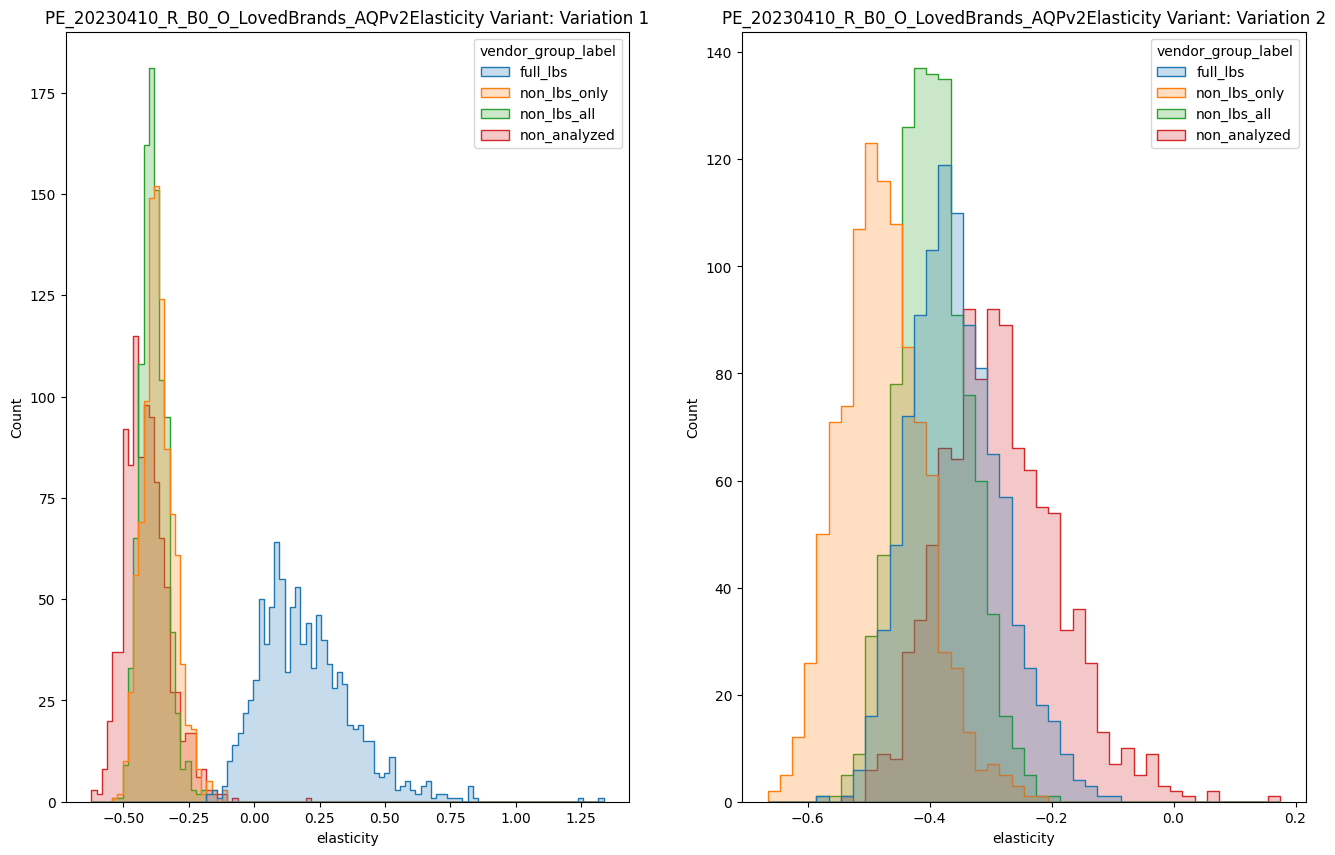

In [81]:
fig, axs =plt.subplots(1,2,figsize=(16,10))
sns.histplot(df_pe_results,x='elasticity',hue='vendor_group_label',element = 'step', binwidth = 0.02, ax = axs[0])
axs[0].set_title(test_pe + "Elasticity Variant: Variation 1")
sns.histplot(df_pe_results_2, x='elasticity', hue = 'vendor_group_label', element = 'step',binwidth = 0.02, ax = axs[1])
axs[1].set_title(test_pe+ "Elasticity Variant: Variation 2")
plt.show()

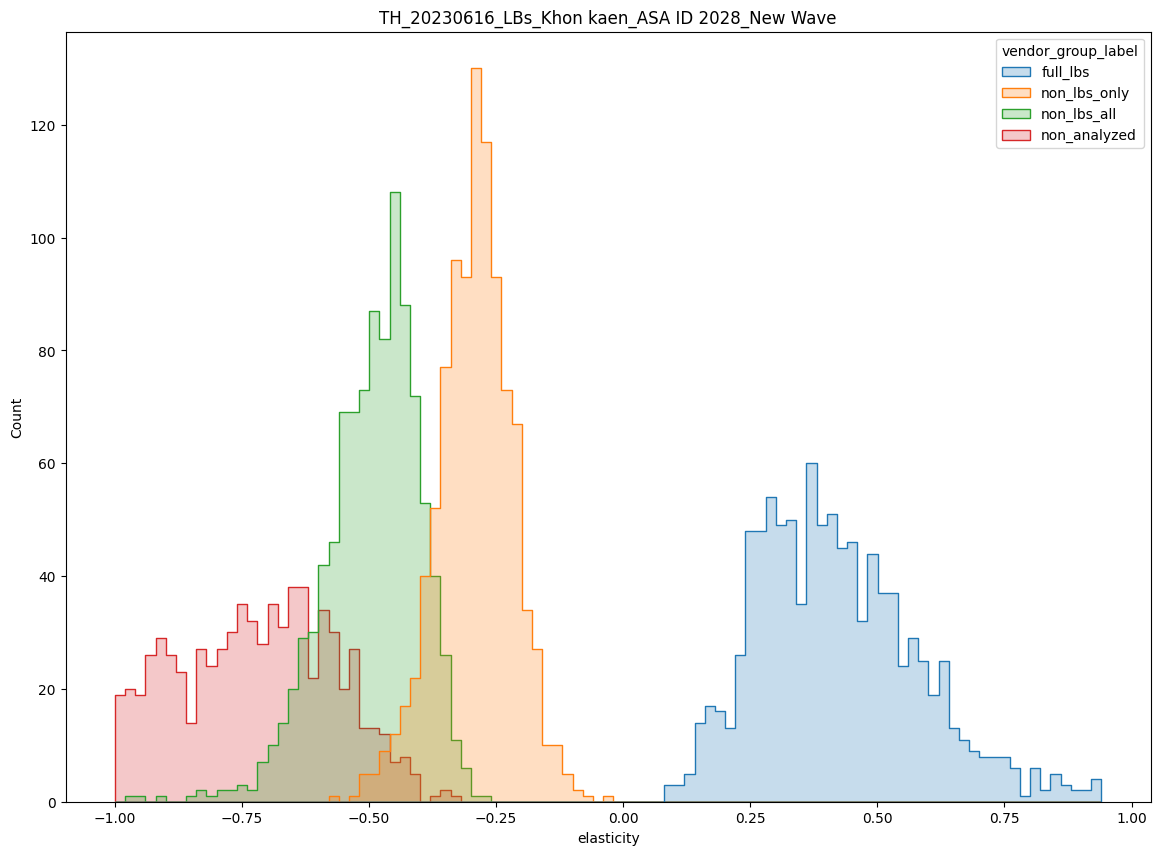

In [133]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.histplot(df_th_1_filtered,x='elasticity',hue='vendor_group_label',element = 'step', binwidth = 0.02)
plt.title("TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave")
plt.show()

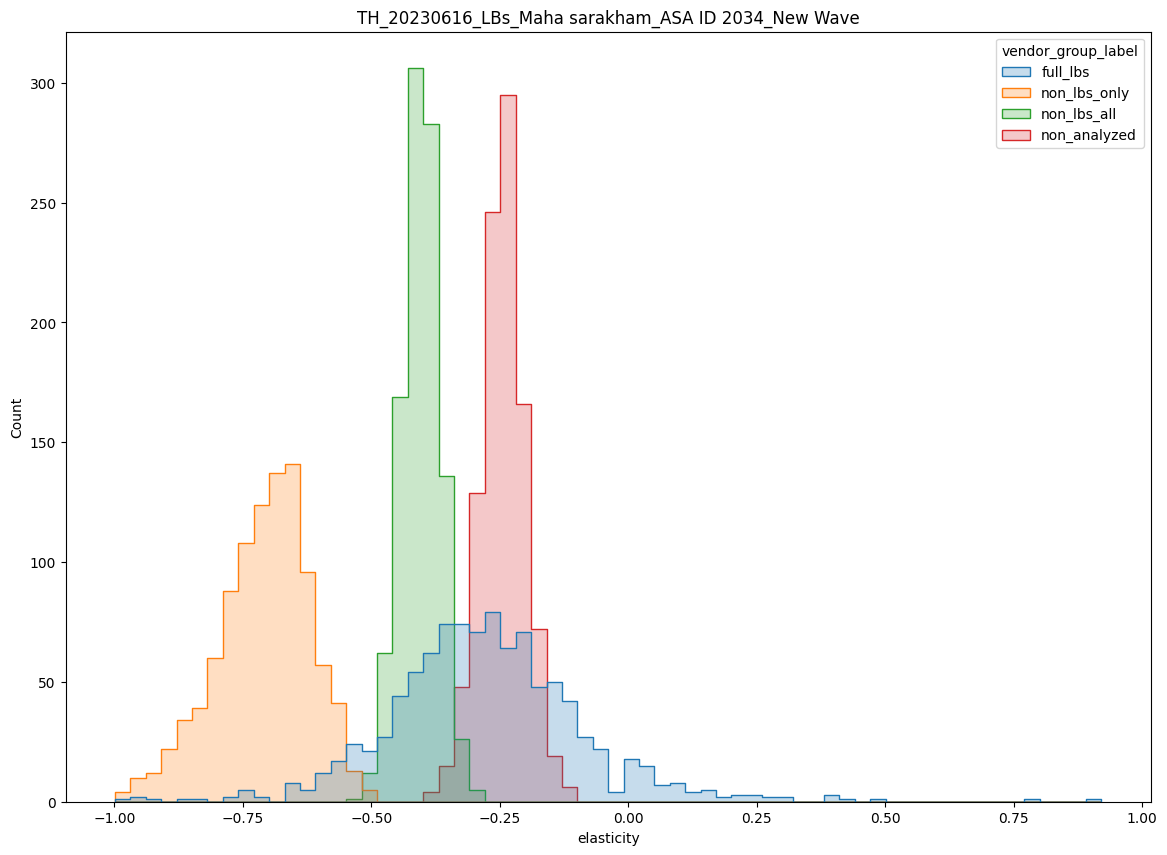

In [130]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.histplot(df_th_2_filtered,x='elasticity',hue='vendor_group_label',element = 'step', binwidth = 0.03)
plt.title("TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave")
plt.show()

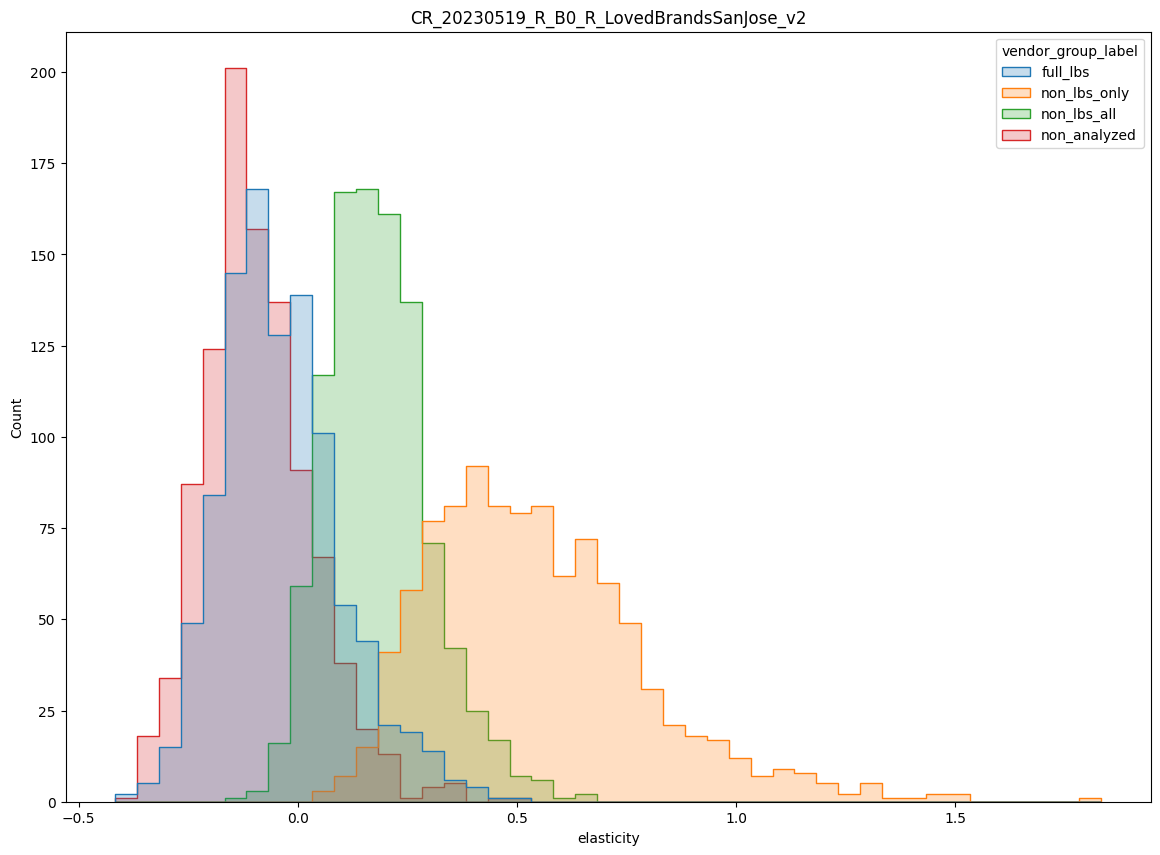

In [126]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.histplot(df_cr_results,x='elasticity',hue='vendor_group_label',element = 'step', binwidth = 0.05)
plt.title("CR_20230519_R_B0_R_LovedBrandsSanJose_v2")
plt.show()